In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import KNN
from eval.metrics import *
from eval.plot import *
import data.valid_crd as valid_crd
import glob
import os
import yaml
import data.helper as helper
import math

In [2]:
## load inputs
test_period = [2001, 2014]
exps  = ['01f207a2', 'd6dd3dc9']
testep = [150, 150]
ref_eval = '01f207a2' #which reference data to be used
compare_methods = ['LOCA', 'QM']

In [3]:
def load_model_run(run_id, est_period, epoch=None, base_dir='/pscratch/sd/k/kas7897/diffDownscale/jobs'):
    run_path = helper.load_run_path(run_id, base_dir)

    flat_dir = os.path.join(run_path, f"{test_period[0]}_{test_period[1]}")

    # Check which structure exists
    data_path = flat_dir
    config_path = os.path.join(run_path, 'train_config.yaml')

    x = torch.load(os.path.join(data_path, 'x.pt'), map_location='cpu').squeeze(-1).numpy()
    x[x<0.254] = 0 
    y = torch.load(os.path.join(data_path, 'y.pt'), map_location='cpu').squeeze(-1).numpy()
    y[y<0.254] = 0
    time = torch.load(os.path.join(data_path, 'time.pt'), map_location='cpu')

    xt = None
    if epoch is not None:
        xt_path = os.path.join(data_path, f'ep{epoch}', 'xt.pt')
        if os.path.exists(xt_path):
            xt = torch.load(xt_path, map_location='cpu')
        xt[xt<0.254] = 0

    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    return {
        'run_path': run_path,
        'x': x,
        'y': y,
        'time': time,
        'xt': xt,
        'config': config
    }

models = []
for i in range(len(exps)):
    model = load_model_run(exps[i], test_period, epoch=testep[i])
    models.append(model)

In [4]:
method_names = []

for i, model in enumerate(models):
    config = model['config']
    
    ref = config['ref']
    degree = config['degree']
    emph_quantile = config['emph_quantile']
    time_scale = config['time_scale']
    ep = testep[i]

    method_name = f"delCLIMAD-BA({ref}_degree{degree}_quantile{emph_quantile}_ep{ep}_{time_scale})"
    method_names.append(method_name)


method_names = method_names + compare_methods

cmip6_dir = models[0]['config']['cmip_dir']
clim = models[0]['config']['clim']
ref = models[0]['config']['ref']
ref_var = models[0]['config']['ref_var']
shapefile_path = None if not  models[0]['config']['spatial_test']  else models[0]['config']['shapefile_filter_path']
train_period = [models[0]['config']['train_start'], models[0]['config']['train_end']]

try:
    spatial_extent = models[0]['config']['spatial_extent_test']
except:
    spatial_extent = models[0]['config']['spatial_extent_val']


ds_sample = xr.open_dataset(f"{cmip6_dir}/{clim}/historical/precipitation/clipped_US.nc")
valid_coords = valid_crd.valid_lat_lon(ds_sample, var_name='pr', shapefile_path=shapefile_path, attrList=spatial_extent)

In [5]:

## Loading competitors
if 'LOCA' in method_names:
    loca = xr.open_dataset(f'{cmip6_dir}/{clim}/historical/precipitation/loca/coarse_USclip.nc')
    loca = loca['pr'].sel(lat=xr.DataArray(valid_coords[:, 0], dims='points'),
                                        lon=xr.DataArray(valid_coords[:, 1], dims='points'),
                                        method='nearest')
    loca = loca.sel(time =slice(f'{test_period[0]}', f'{test_period[1]}')).values

    #unit conversion
    loca = loca*86400




if 'QM' in method_names:
    QM_bench = f'benchmark/QuantileMapping/conus/{clim}-{ref}/{train_period}_historical_{test_period}.pt'
    QM_debiased = torch.load(QM_bench, weights_only=False).squeeze(-1)
    QM_debiased = QM_debiased*86400

In [6]:
## this block filters 'y' based on 'x' calender
for model in models:
    time = model['time']
    
    x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
    x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
    # Generate a daily time array following the standard Gregorian calendar
    y_time = pd.date_range(start=f"{test_period[0]}-01-01", end=f"{test_period[1]}-12-31", freq="D")

    # Convert to NumPy array for indexing and comparison
    y_time_np = y_time.to_numpy()

    # Find indices where observed time matches model time
    matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

    model['y'] = model['y'][matched_indices,:]
    model['x_time_np'] = x_time_np

    # loca = loca[matched_indices, :]


ref_eval_data = models[exps.index(ref_eval)]['y']


### 10 Individual Locations Analysis

In [7]:
cities = {
    "Pittsburgh": [40.437, -80.079],
    "Phoenix": [33.431, -112.008],
    "ARM site": [36.608, -97.488],
    "Sioux City": [42.387, -96.369],
    "Boulder": [39.998, -105.268],
    "Birmingham": [33.568, -86.751],
    "Ft Logan": [46.543, -110.902],
    "Seattle": [47.545, -122.243],
    "Yosemite": [37.749, -119.590],
    "Orlando": [28.450, -81.741],
}

# Convert to array
city_names = list(cities.keys())
city_coords = np.array(list(cities.values()))  # shape (10, 2)

# Assuming valid_coords is already loaded as a numpy array (lat, lon)
# Compute distances between each city and all valid_coords
def find_nearest_indices(city_coords, valid_coords):
    nearest_indices = []
    nearest_coords = []

    for coord in city_coords:
        # Broadcasting subtraction
        dists = np.linalg.norm(valid_coords - coord, axis=1)
        idx = np.argmin(dists)
        nearest_indices.append(idx)
        nearest_coords.append(valid_coords[idx])

    return nearest_indices, np.array(nearest_coords)

# Call the function
nearest_indices, nearest_coords = find_nearest_indices(city_coords, valid_coords)


In [45]:
def calc_climatology_precip_intensity(prcp, timestamps, wet_threshold=1.0, window=30):
    """
    Compute daily climatology of precipitation intensity (mean precip on wet days),
    by first computing per-year DOY intensities, then averaging.

    Parameters:
        prcp (np.ndarray): (time, n_coords) daily precipitation
        timestamps (array-like): (time,) datetime64 array
        wet_threshold (float): threshold for wet days (default 1.0 mm/day)
        window (int): moving average window in days (default 30)

    Returns:
        intensity_clim (np.ndarray): (365, n_coords) array of climatological intensities
    """
    df = pd.DataFrame({
        'year': pd.to_datetime(timestamps).year,
        'doy': pd.to_datetime(timestamps).dayofyear
    })
    df['doy'] = df['doy'].clip(upper=365)

    years = df['year'].unique()
    n_coords = prcp.shape[1]
    per_year_intensity = {year: np.full((365, n_coords), np.nan) for year in years}

    for year in years:
        year_idx = df['year'] == year
        prcp_year = prcp[year_idx]
        doy_year = df.loc[year_idx, 'doy'].values

        # Prepare day-of-year bins
        for doy in range(1, 366):
            # 30-day window: circular for early/late year
            half_win = window // 2
            window_range = [(doy - half_win + i - 1) % 365 + 1 for i in range(window)]
            day_mask = np.isin(doy_year, window_range)

            if not np.any(day_mask):
                continue

            data_window = prcp_year[day_mask]
            wet_mask = data_window > wet_threshold
            wet_counts = wet_mask.sum(axis=0)

            with np.errstate(invalid='ignore', divide='ignore'):
                intensity = np.where(
                    wet_counts > 0,
                    data_window.sum(axis=0) / wet_counts,
                    np.nan
                )

            per_year_intensity[year][doy - 1, :] = intensity

    # Stack years → (n_years, 365, n_coords) → then take mean over years
    intensity_all_years = np.stack(list(per_year_intensity.values()), axis=0)
    intensity_clim = np.nanmean(intensity_all_years, axis=0)  # (365, n_coords)

    return intensity_clim


/tmp/ipykernel_1096077/702040596.py:55: RuntimeWarning: Mean of empty slice
  intensity_clim = np.nanmean(intensity_all_years, axis=0)  # (365, n_coords)
/tmp/ipykernel_1096077/702040596.py:55: RuntimeWarning: Mean of empty slice
  intensity_clim = np.nanmean(intensity_all_years, axis=0)  # (365, n_coords)
/tmp/ipykernel_1096077/702040596.py:55: RuntimeWarning: Mean of empty slice
  intensity_clim = np.nanmean(intensity_all_years, axis=0)  # (365, n_coords)
/tmp/ipykernel_1096077/702040596.py:55: RuntimeWarning: Mean of empty slice
  intensity_clim = np.nanmean(intensity_all_years, axis=0)  # (365, n_coords)
/tmp/ipykernel_1096077/702040596.py:55: RuntimeWarning: Mean of empty slice
  intensity_clim = np.nanmean(intensity_all_years, axis=0)  # (365, n_coords)
/tmp/ipykernel_1096077/702040596.py:55: RuntimeWarning: Mean of empty slice
  intensity_clim = np.nanmean(intensity_all_years, axis=0)  # (365, n_coords)
/tmp/ipykernel_1096077/702040596.py:55: RuntimeWarning: Mean of empty slice


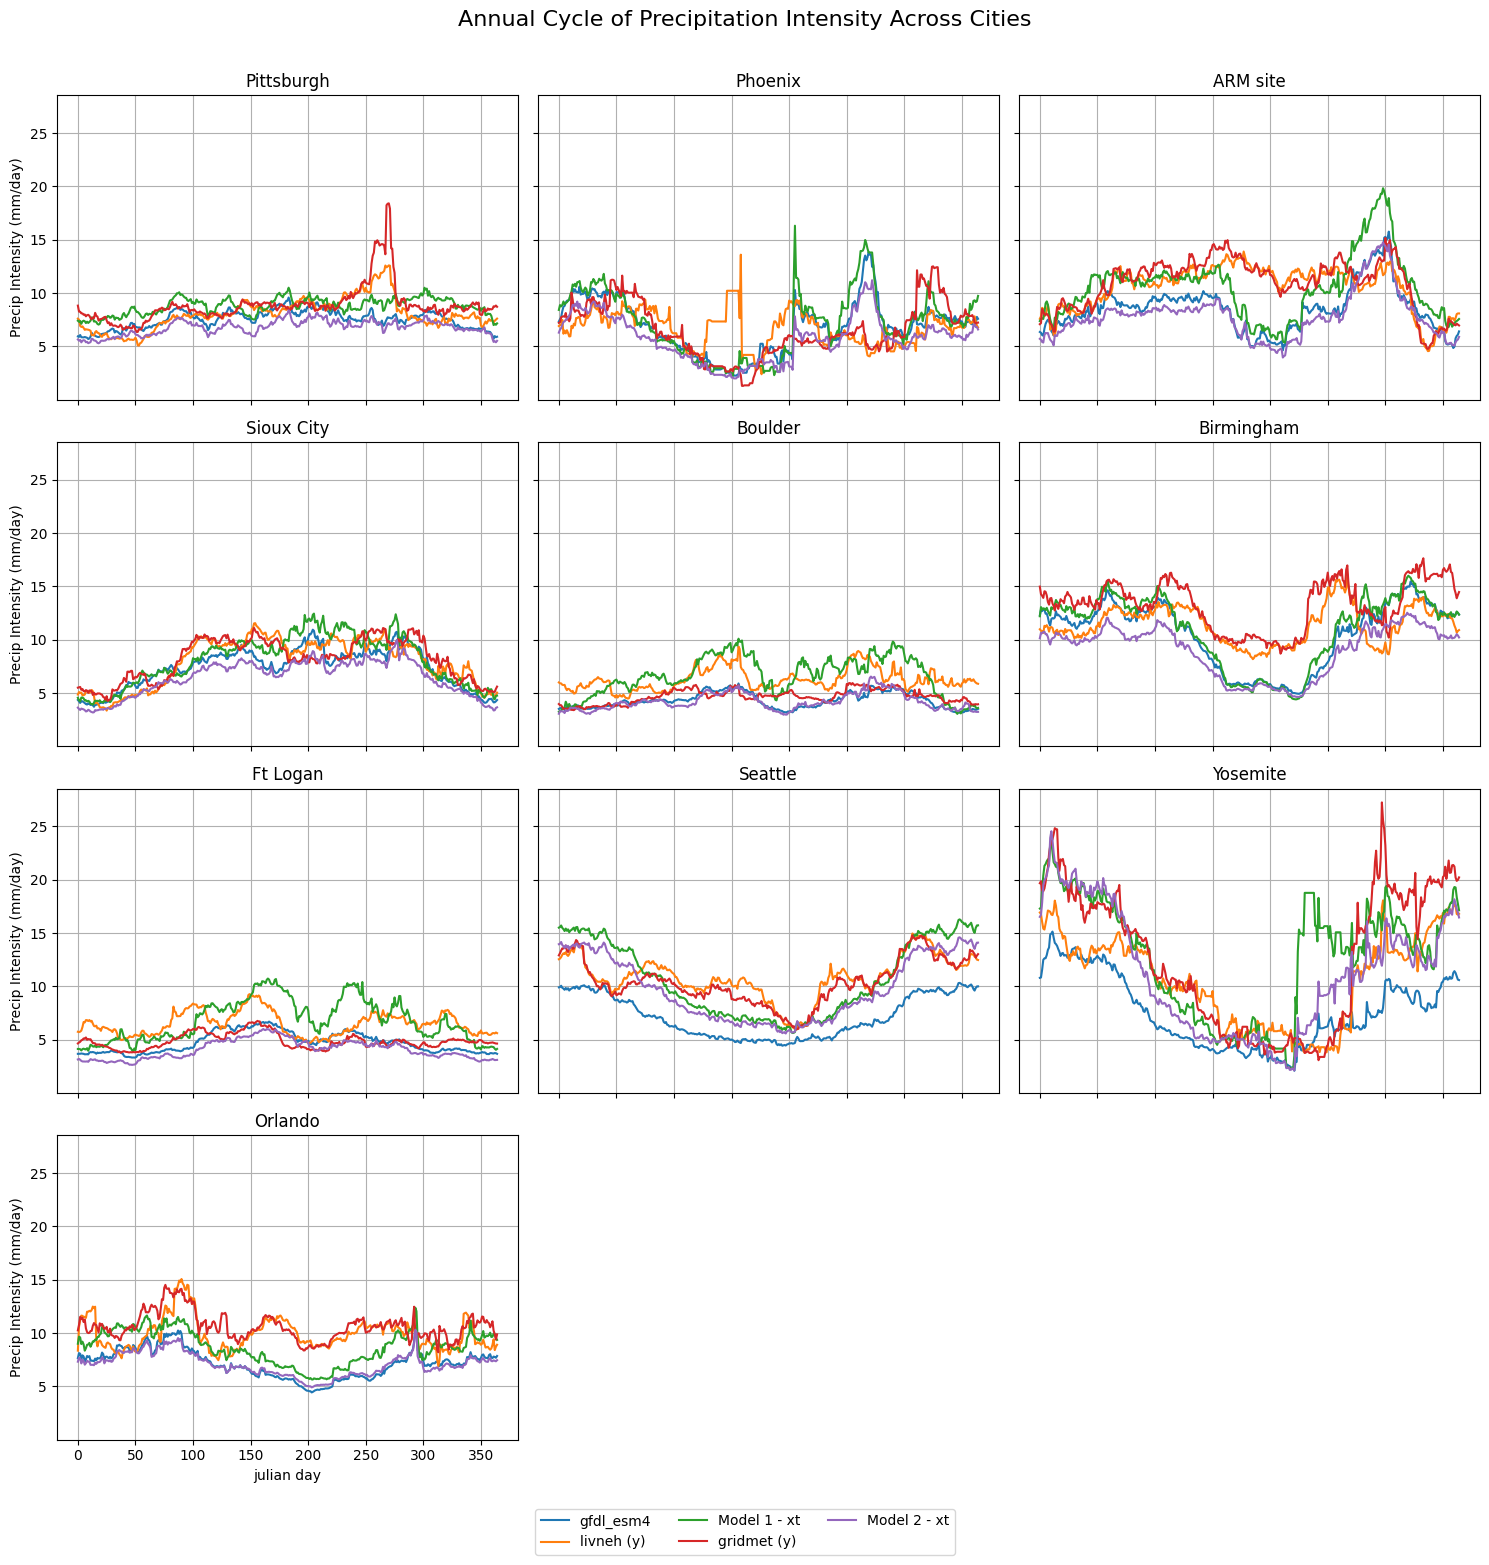

In [50]:
num_cities = len(cities)
ncols = 3
nrows = math.ceil(num_cities / ncols)
scale = 'julian day'

fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()

all_handles = []
all_labels = []

# Compute x_intensity only once
x_intensity = calc_climatology_precip_intensity(models[0]['x'], models[0]['x_time_np'])
clim_label = models[0]['config']['clim']

for j in range(num_cities):
    ax = axs[j]
    city_name = list(cities.keys())[j]
    loc = nearest_indices[j]

    # Plot observed (climate) intensity once
    l1, = ax.plot(x_intensity[:, loc], label=f'{clim_label}')
    if j == 0:
        all_handles.append(l1)
        all_labels.append(f'{clim_label}')

    # Now plot model results for this location
    for i in range(len(models)):
        y_intensity = calc_climatology_precip_intensity(models[i]['y'], models[i]['x_time_np'])
        xt_intensity = calc_climatology_precip_intensity(models[i]['xt'], models[i]['x_time_np'])

        ref_label = models[i]['config']['ref']

        l2, = ax.plot(y_intensity[:, loc], label=f'{ref_label} (y)')
        l3, = ax.plot(xt_intensity[:, loc], label=f'Model {i+1} - xt')

        if j == 0:
            all_handles.extend([l2, l3])
            all_labels.extend([f'{ref_label} (y)', f'Model {i+1} - xt'])

    # Format each subplot
    ax.set_title(city_name)
    ax.grid(True)
    if j % ncols == 0:
        ax.set_ylabel('Precip Intensity (mm/day)')
    if j >= (nrows - 1) * ncols:
        ax.set_xlabel(scale)

# Hide unused axes
for k in range(num_cities, len(axs)):
    fig.delaxes(axs[k])

# Final layout and legend
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=3, fontsize='medium')
fig.suptitle('Annual Cycle of Precipitation Intensity Across Cities', fontsize=16)
plt.show()


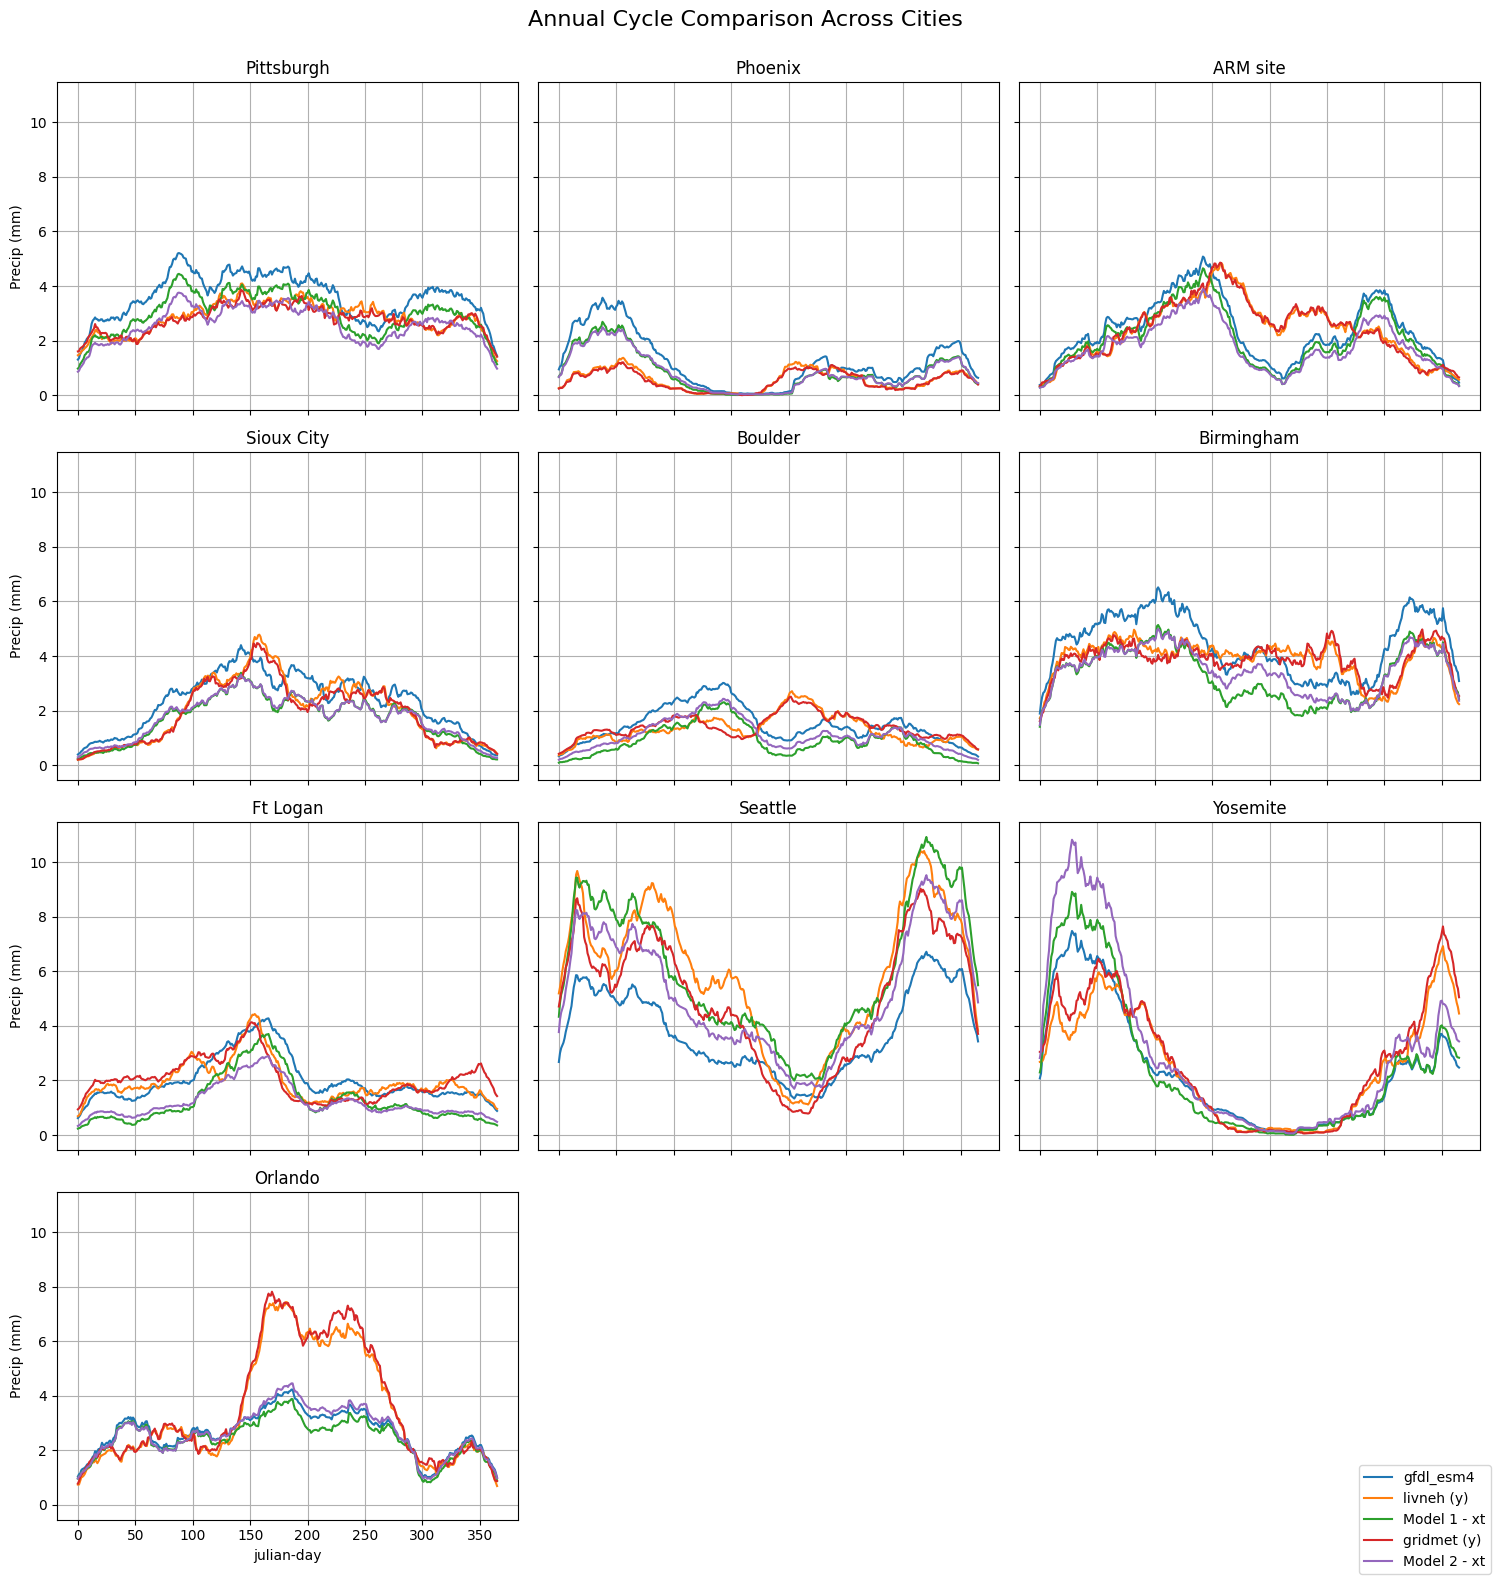

In [11]:
def moving_average(arr, window=5):
    return np.convolve(arr, np.ones(window)/window, mode='same')

window_size = 30
scale = 'julian-day'
num_cities = len(cities)

# Calculate subplot grid size (e.g., 3x4 for 10 cities)
ncols = 3
nrows = math.ceil(num_cities / ncols)


fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True, sharey=True)
axs = axs.flatten()  # for easy indexing

time_labels = helper.extract_time_labels(models[0]['x_time_np'], label_type=scale)
label_dummies = pd.get_dummies(time_labels)
weights_np = label_dummies.div(label_dummies.sum(axis=0), axis=1).values.astype(np.float32)

# For legend collection
all_handles = []
all_labels = []

for j in range(num_cities):
    ax = axs[j]
    city_name = list(cities.keys())[j]
    loc = nearest_indices[j]

    scaled_x = np.einsum('ts,tm->sm', models[0]['x'], weights_np)
    smoothed_x = moving_average(scaled_x[loc], window_size)
    clim_label = models[0]['config']['clim']
    l1, = ax.plot(smoothed_x, label=f'{clim_label}')

    # Save one handle-label pair for legend
    if j == 0:
        all_handles.append(l1)
        all_labels.append(f'{clim_label}')

    for i in range(len(models)):
        scaled_y = np.einsum('ts,tm->sm', models[i]['y'], weights_np)
        scaled_xt = np.einsum('ts,tm->sm', models[i]['xt'], weights_np)

        smoothed_y = moving_average(scaled_y[loc], window_size)
        smoothed_xt = moving_average(scaled_xt[loc], window_size)
        ref_label = models[i]['config']['ref']

        l2, = ax.plot(smoothed_y, label=f'{ref_label} (y)')
        l3, = ax.plot(smoothed_xt, label=f'Model {i+1} - xt')

        if j == 0:
            all_handles.extend([l2, l3])
            all_labels.extend([f'{ref_label} (y)', f'Model {i+1} - xt'])

    ax.set_title(city_name)
    ax.grid(True)
    if j % ncols == 0:
        ax.set_ylabel('Precip (mm)')
    if j >= (nrows - 1) * ncols:
        ax.set_xlabel(scale)

# Hide any unused subplots
for k in range(num_cities, len(axs)):
    fig.delaxes(axs[k])

# Shared legend outside all plots
fig.legend(all_handles, all_labels, loc='lower right')

fig.suptitle('Annual Cycle Comparison Across Cities', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [9]:
num_cities = len(cities)

for j in range(num_cities):
    print(list(cities.keys())[j])
    loc = nearest_indices[j]


    annual_max_x = calculate_annual_maxima(models[0]['x'], models[0]['x_time_np'])
    annual_max_y = calculate_annual_maxima(models[0]['y'], models[0]['x_time_np'])
    annual_max_xt = calculate_annual_maxima(models[0]['xt'], models[0]['x_time_np'])
    annual_max_loca = calculate_annual_maxima(loca, models[0]['x_time_np'])


    metrics_x = fit_stationary_gev(annual_max_x[:,loc])
    metrics_y = fit_stationary_gev(annual_max_y[:,loc])
    metrics_xt = fit_stationary_gev(annual_max_xt[:,loc])
    metrics_loca = fit_stationary_gev(annual_max_loca[:,loc])


    for rp in [5, 10, 20, 50, 100]:
        vals_x = metrics_x[rp]
        vals_y = metrics_y[rp]
        vals_xt = metrics_xt[rp]
        vals_loca = metrics_loca[rp]

        print(f"RAW--> {rp}-year RL: Low={vals_x['low']:.2f}, Best={vals_x['best']:.2f}, High={vals_x['high']:.2f}")
        print(f"Livneh--> {rp}-year RL: Low={vals_y['low']:.2f}, Best={vals_y['best']:.2f}, High={vals_y['high']:.2f}")
        print(f"dCLIMAD-BA--> {rp}-year RL: Low={vals_xt['low']:.2f}, Best={vals_xt['best']:.2f}, High={vals_xt['high']:.2f}")
        print(f"LOCA-->{rp}-year RL: Low={vals_loca['low']:.2f}, Best={vals_loca['best']:.2f}, High={vals_loca['high']:.2f}")

Pittsburgh
RAW--> 5-year RL: Low=59.17, Best=72.38, High=148910.21
Livneh--> 5-year RL: Low=50.20, Best=61.79, High=193023.78
dCLIMAD-BA--> 5-year RL: Low=48.26, Best=56.69, High=83912.26
LOCA-->5-year RL: Low=47.83, Best=58.41, High=393215.27
RAW--> 10-year RL: Low=63.11, Best=84.53, High=65432778.31
Livneh--> 10-year RL: Low=53.18, Best=74.78, High=83512686.95
dCLIMAD-BA--> 10-year RL: Low=50.29, Best=62.60, High=32721492.39
LOCA-->10-year RL: Low=53.82, Best=74.44, High=263449746.27
RAW--> 20-year RL: Low=64.40, Best=97.76, High=25325764454.60
Livneh--> 20-year RL: Low=55.45, Best=90.51, High=25162665243.43
dCLIMAD-BA--> 20-year RL: Low=50.47, Best=67.88, High=10800849048.70
LOCA-->20-year RL: Low=60.16, Best=98.40, High=196251607665.37
RAW--> 50-year RL: Low=65.39, Best=117.48, High=44558827068688.84
Livneh--> 50-year RL: Low=57.00, Best=116.99, High=52709917037419.27
dCLIMAD-BA--> 50-year RL: Low=50.56, Best=74.20, High=21796786205611.64
LOCA-->50-year RL: Low=68.41, Best=149.80, 

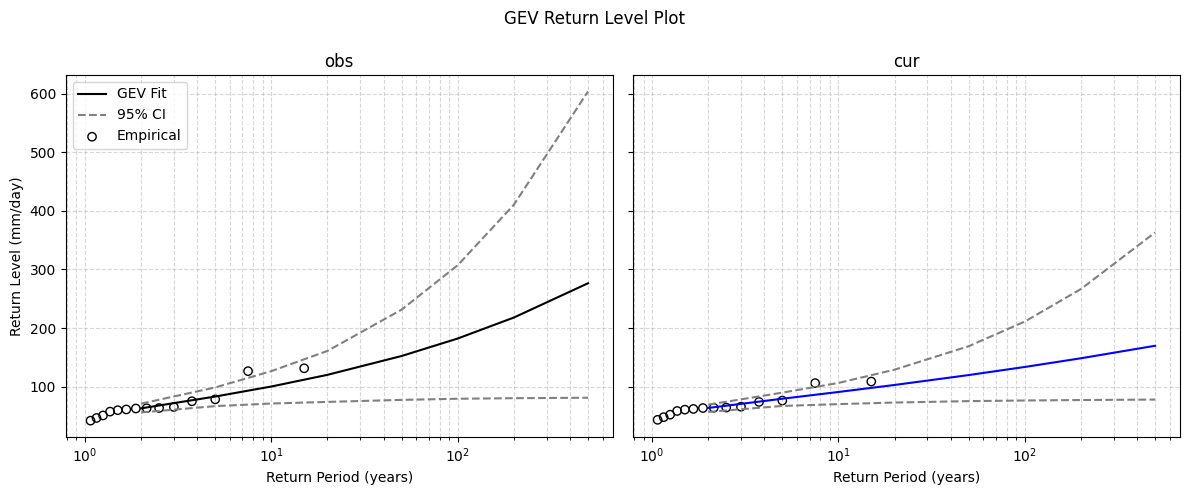

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme


def plot_2panel_gev(obs_data, model_data, return_periods=[2, 5, 10, 20, 50, 100, 200, 500]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for ax, data, title, color in zip(
        axs,
        [obs_data, model_data],
        ['obs', 'cur'],
        ['black', 'blue']
    ):
        data = np.sort(data)
        n = len(data)
        empirical_rps = 1 / (1 - (np.arange(1, n+1) / (n + 1)))

        # Fit and return levels
        best, low, high = fit_stationary_gev(data, return_periods)
        
        ax.plot(return_periods, best, color=color, label='GEV Fit')
        ax.plot(return_periods, low, '--', color='gray', label='95% CI' if title == 'obs' else None)
        ax.plot(return_periods, high, '--', color='gray')
        ax.scatter(empirical_rps, data, facecolors='none', edgecolors='black', label='Empirical')

        ax.set_xscale('log')
        ax.set_title(title)
        ax.set_xlabel('Return Period (years)')
        ax.grid(True, which='both', linestyle='--', alpha=0.5)
        if title == 'obs':
            ax.set_ylabel('Return Level (mm/day)')
            ax.legend()

    plt.suptitle("GEV Return Level Plot")
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


plot_2panel_gev(annual_max_xt[:,20], annual_max_x[:,20])


In [9]:
annual_max_x = calculate_annual_maxima(models[0]['x'], models[0]['x_time_np'])
annual_max_xt = calculate_annual_maxima(models[0]['xt'], models[0]['x_time_np'])

annual_max_y = calculate_annual_maxima(models[0]['y'], models[0]['x_time_np'])

In [10]:
metrics_y = fit_stationary_gev(annual_max_y[:,20])

⚠️ Unstable shape (ξ = -4.883) or exploding return level detected. Switching to Gumbel fallback.


In [11]:
metrics_y


(array([105.63684921, 125.46384998, 144.48238514, 169.09992808,
        187.54731231]),
 None,
 None)

In [70]:
k1 =  fit_gev_and_ci(data = annual_max_xt[:,20], return_periods=[2, 5, 10, 20, 50, 100, 200, 500], n_bootstrap=1000)

In [72]:
k2 =  fit_gev_and_ci(data = annual_max_y[:,20], return_periods=[2, 5, 10, 20, 50, 100, 200, 500], n_bootstrap=1000)

In [77]:
metrics_x

{5: {'best': 191.87073661841765,
  'low': 76.13831898447498,
  'high': 990919.5575974458},
 10: {'best': 5902.102543271711,
  'low': 99.40520860569939,
  'high': 998943920.4710741},
 20: {'best': 197073.24092601278,
  'low': 105.41200142946947,
  'high': 969991630013.2736},
 50: {'best': 18645753.130893122,
  'low': 124.48196386510176,
  'high': 6882777141070225.0},
 100: {'best': 564086097.3744956,
  'low': 127.10554515895701,
  'high': 4.867225913907757e+18}}

In [ ]:



metrics_y = fit_stationary_gev1(annual_max_y[:,20])
metrics_x = fit_stationary_gev1(annual_max_x[:,20])
metrics_xt = fit_stationary_gev1(annual_max_xt[:,20])

⚠️ Unstable shape (ξ = -4.883) or exploding return level detected. Switching to Gumbel fallback.


In [81]:
metrics_y

{5: {'best': 105.63684920790173, 'low': None, 'high': None},
 10: {'best': 125.46384997871601, 'low': None, 'high': None},
 20: {'best': 144.48238513559454, 'low': None, 'high': None},
 50: {'best': 169.0999280848215, 'low': None, 'high': None},
 100: {'best': 187.54731231311473, 'low': None, 'high': None}}

In [83]:
metrics_x

{5: {'best': 79.36766119703745,
  'low': 67.19877252400005,
  'high': 89.22204193286126},
 10: {'best': 90.90010240690525,
  'low': 70.6951349080418,
  'high': 105.81578003729159},
 20: {'best': 102.86417146573977,
  'low': 72.91402212229498,
  'high': 127.35689598734231},
 50: {'best': 119.77886783539574,
  'low': 75.27369763175636,
  'high': 171.29338643344826},
 100: {'best': 133.60246317108567,
  'low': 76.59424480425444,
  'high': 215.79701149204828}}

In [84]:
k

(array([ 63.60861264,  79.3676612 ,  90.90010241, 102.86417147,
        119.77886784, 133.60246317, 148.43825779, 169.7733486 ]),
 array([57.08682082, 66.74585563, 69.92555458, 71.9611624 , 73.44242453,
        74.08130312, 74.59084165, 74.95012779]),
 array([  72.43328284,   90.95612772,  108.90053755,  144.04421515,
         243.03551065,  379.76591357,  644.06373955, 1409.68118763]),
 array([0.5  , 0.8  , 0.9  , 0.95 , 0.98 , 0.99 , 0.995, 0.998]))

In [85]:
metrics_x

{5: {'best': 79.36766119703745,
  'low': 67.19877252400005,
  'high': 89.22204193286126},
 10: {'best': 90.90010240690525,
  'low': 70.6951349080418,
  'high': 105.81578003729159},
 20: {'best': 102.86417146573977,
  'low': 72.91402212229498,
  'high': 127.35689598734231},
 50: {'best': 119.77886783539574,
  'low': 75.27369763175636,
  'high': 171.29338643344826},
 100: {'best': 133.60246317108567,
  'low': 76.59424480425444,
  'high': 215.79701149204828}}